In [49]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import probplot
import seaborn as sns
import matplotlib.pyplot as plt

**Продукт**: 
 - SaaS, подписка, аналитика в соц. сетях. Пользователь может отслеживать свою активность и своих друзей, подписавшись в сервисе
 
**Тестируемое изменение**: 
 - изменение h1 и подписи в кнопке на первом экране главной страницы. Цель – зацепить пользователя

In [6]:
df = pd.read_csv('hw2_1.csv', encoding='utf-8', delimiter=';', index_col=0)
df['sessionDuration'] = pd.to_numeric([i.replace(',','.') for i in df['sessionDuration'].values])
df.head()

,date,deviceCategory,sourceMedium,experimentVariant,clickButtonOnMain,sessionDuration
1,2019-11-27,desktop,(direct) / (none),control,1,123.109765
2,2019-11-27,mobile,maz.com / referral,test,1,135.604001
3,2019-11-27,mobile,(direct) / (none),test,1,134.451017
4,2019-11-27,desktop,google / organic,test,1,130.691087
5,2019-11-27,mobile,google / organic,control,1,117.617311


In [4]:
df.shape

(2943, 7)

**Проверим, есть ли значимое изменение в большую или меньшую сторону у клика на целевую кнопку  (контроль – Check, тест – Find out in 30 seconds)**

Будем использовать критерий долей для распределения Бернулли. Проверяется гипотеза о параметрах распределений в группах. Если
доверительный интервал оценённых разниц распределений близок к нулю, то это значит, что на уровне значимости 95 % мы не сможем 
отвергнуть нулевую гипотезу.

In [10]:
df['experimentVariant'].value_counts(normalize=True)

control    0.504587
test       0.495413
Name: experimentVariant, dtype: float64

Размер целевой и контрольной групп примерно одинаков, это хорошо. Соблюдается условие Z теста для двух групп.

In [17]:
# Z-статистика для разности двух долей
def proportion_diff(test, control, action: str):
    #расчёт размеров целевой и контрольной групп
    n1 = test.shape[0]
    n2 = control.shape[0]
    
    #оценка долей
    p_test =  np.sum(test[action]) / n1
    p_control = np.sum(control[action]) / n2
    
    #оценка разности долей
    P = (p_test*n1 + p_control*n2) / (n1 + n2)
    
    #расчёт Z-статистики
    Z = (p_test - p_control) / np.sqrt(P*(1 - P)*(1/n1 + 1/n2))
    
    return Z

In [41]:
# расчёт p-value
def proportion_pvalue(Z, method: str):
    assert method in ['less', 'greater', 'two-sided'], 'Неверно указан метод'
    
    #расчёт p-значения в зависимости от типа теста 
    if method == 'two-sided':
        return (1 - norm.cdf(np.abs(Z)))*2
    
    if method == 'greater':
        return 1 - norm.cdf(Z)
    
    if method == 'less':
        return norm.cdf(Z)

In [22]:
# расчёт границ доверительного интервала
def proportion_confidence(test, control, action: str, alpha: float):
    n1 = test.shape[0]
    n2 = control.shape[0]
    
    p_test =  np.sum(test[action]) / n1
    p_control = np.sum(control[action]) / n2
    
    z = norm.ppf(1 - alpha / 2.)
    
    left_bound = (p_test - p_control) - z * np.sqrt(p_test * (1 - p_test) / n1 + p_control * (1 - p_control) / n2)
    right_bound = (p_test - p_control) + z * np.sqrt(p_test * (1 - p_test) / n1 + p_control * (1 - p_control) / n2)
    
    return (left_bound, right_bound)

In [43]:
proportion_diff(test=df.loc[df['experimentVariant'] == 'test'],
                                      control=df.loc[df['experimentVariant'] == 'control'],
                                      action='clickButtonOnMain')

-3.294710114036112

In [44]:
proportion_pvalue(Z=-3.294710114036112, method = 'two-sided')

0.0009852325829367015

In [47]:
proportion_confidence(test=df.loc[df['experimentVariant'] == 'test'],
                                      control=df.loc[df['experimentVariant'] == 'control'],
                                      action='clickButtonOnMain', alpha=0.05)

(-0.060647203611189734, -0.015496954014449383)

P значение крайне мало, доверительный интервал довольно узкий и не очень близок к нулю.

**Проверим, изменилось ли время проведенное на сайте в рамках сеанса**.

Оценим визуально форму и квантили распределения.

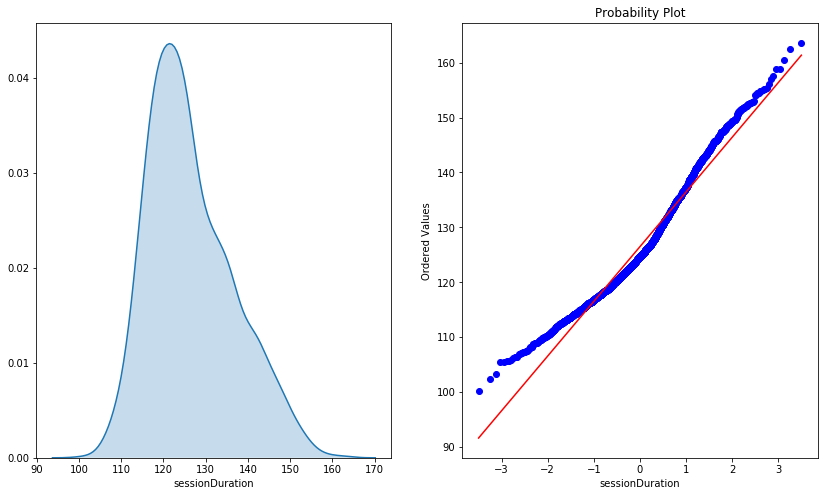

In [53]:
plt.figure(figsize=(14,8))

plt.subplot(121)
sns.kdeplot(df['sessionDuration'], shade=True, legend=False)
plt.xlabel('sessionDuration')

plt.subplot(122)
probplot(df['sessionDuration'], dist='norm', plot=plt);
plt.xlabel('sessionDuration');

Выглядит около нормальным. Похоже на распределение Стьюдента, только немного скошено влево. Проверим дисперсии.

In [55]:
np.var(df.loc[df['experimentVariant'] == 'test', 'sessionDuration'], ddof=1)

94.08869063438061

In [56]:
np.var(df.loc[df['experimentVariant'] == 'control', 'sessionDuration'], ddof=1)

26.868172374172342

А вот дисперсии различаются очень сильно, поэтому прийдётся использовать критерий Манна-Уитни.

**Выводы и гипотезы**